In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss

In [8]:
# Loading data
key = 'https://getfile.dokpub.com/yandex/get/'
url = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'

df = pd.read_csv(key+url)

Let's check if there are users who fall into both the first and second groups

In [9]:
user_id_1_check = pd.crosstab(df.user_id_1, df.group).reset_index()
user_id_1_check['min'] = user_id_1_check[[0, 1]].min(axis=1)
user_id_1_check['min'].unique()

array([0])

In [10]:
user_id_2_check = pd.crosstab(df.user_id_2, df.group).reset_index()
user_id_2_check['min'] = user_id_2_check[[0, 1]].min(axis=1)
user_id_2_check['min'].unique()

array([0])

Users who are in 2 groups at the same time -- none

To evaluate the effectiveness of the new questionnaire retrieval system, we formulate 2 questions:<br>
1. Has user activity increased in general?<br>
For this purpose, let's count how many actions users have performed (match+not_match). This sign is rather indirect, as the activity is not directly related to the quality of questionnaire matching. In any case, our ultimate goal is the popularity and revenue of the application, and this factor has a positive impact on the application as a whole, because the more people are active in our application, the more successful our service as a whole is.<br>
<br>
2. Has the conversion rate of likes increased?<br>
To do this, we divide the number of likes by the total activity. This figure directly reflects how well the new algorithm works.

### 1 question

In [23]:
# Count activity for 1 user from user_id_1
first_group = df.query('group == 0') \
                .groupby('user_id_1') \
                .agg({'is_match': 'count'}) \
                .reset_index() \
                .rename(columns={'user_id_1': 'user_id_2'})

In [24]:
# Count activity for 1 user from user_id_2, join to 1 table
first_group_activity = first_group.merge(df.query('group == 0').groupby('user_id_2').agg({'is_match': 'count'}).reset_index(),
                                         how='left',
                                         on='user_id_2'
                                        )
first_group_activity            

,user_id_2,is_match_x,is_match_y
0,4,9,8
1,10,6,14
2,12,12,8
3,14,8,8
4,15,20,12
...,...,...,...
496,994,9,20
497,995,8,6
498,996,8,6
499,997,12,14


In [25]:
# Counting activity
first_group_activity['activity'] = first_group_activity.is_match_x + first_group_activity.is_match_y
first_group_activity = first_group_activity.drop(columns=['is_match_x', 'is_match_y'])
first_group_activity = first_group_activity.rename(columns={'user_id_2': 'user_id'})

In [26]:
# Do the same with the test group
second_group = df.query('group == 1') \
                 .groupby('user_id_1') \
                 .agg({'is_match': 'count'}) \
                 .reset_index() \
                 .rename(columns={'user_id_1': 'user_id_2'})

In [27]:
second_group_activity = second_group.merge(df.query('group == 1').groupby('user_id_2').agg({'is_match': 'count'}).reset_index(),
                                           how='left',
                                           on='user_id_2'
                                          )
                                

In [28]:
second_group_activity['activity'] = second_group_activity.is_match_x + second_group_activity.is_match_y
second_group_activity = second_group_activity.drop(columns=['is_match_x', 'is_match_y'])
second_group_activity = second_group_activity.rename(columns={'user_id_2': 'user_id'})

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


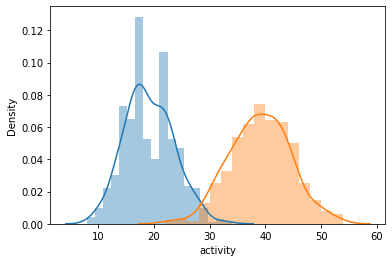

In [29]:
sns.distplot(first_group_activity.activity)
sns.distplot(second_group_activity.activity)

In [30]:
# Since the distributions are normal and we have 2 independent groups of observations, we apply the t-test
ss.ttest_ind(first_group_activity.activity, second_group_activity.activity)

Ttest_indResult(statistic=-62.837086115525075, pvalue=0.0)

The p-value is less than 0.05, so we conclude that the averages in the two groups are significantly different

In [31]:
second_group_activity.activity.mean() / first_group_activity.activity.mean()

2.036929451557539

#### We conclude that the averages are significantly different and the new algorithm has significantly increased the average user activity (by 2 times).

### 2 question

In [32]:
# We do the same actions as in question 2, but we calculate the conversion rate of likes (likes divided by the total activity).
first_group_a = df.query('group == 0') \
                  .groupby('user_id_1') \
                  .agg({'is_match': ['count', 'sum']})

first_group_a.columns = first_group_a.columns.droplevel(0)

first_group_a = first_group_a.reset_index().rename(columns={'user_id_1': 'user_id'})

In [33]:
first_group_b = df.query('group == 0') \
                  .groupby('user_id_2') \
                  .agg({'is_match': ['count', 'sum']})

first_group_b.columns = first_group_b.columns.droplevel(0)

first_group_b = first_group_b.reset_index().rename(columns={'user_id_2': 'user_id'})

In [34]:
first_group = first_group_a.merge(first_group_b, how="left", on='user_id')

In [35]:
first_group['CR'] = (first_group.sum_x + first_group.sum_y) / (first_group.count_x + first_group.count_y)

first_group_CR = first_group.drop(columns=['sum_x', 'sum_y', 'count_x', 'count_y'])

In [36]:
second_group_a = df.query('group == 1') \
                   .groupby('user_id_1') \
                   .agg({'is_match': ['count', 'sum']})

second_group_a.columns = second_group_a.columns.droplevel(0)

second_group_a = second_group_a.reset_index().rename(columns={'user_id_1': 'user_id'})

In [37]:
second_group_b = df.query('group == 1') \
                   .groupby('user_id_2') \
                   .agg({'is_match': ['count', 'sum']})

second_group_b.columns = second_group_b.columns.droplevel(0)

second_group_b = second_group_b.reset_index().rename(columns={'user_id_2': 'user_id'})

In [38]:
second_group = second_group_a.merge(second_group_b, how="left", on='user_id')

In [39]:
second_group['CR'] = (second_group.sum_x + second_group.sum_y) / (second_group.count_x + second_group.count_y)

second_group_CR = second_group.drop(columns=['sum_x', 'sum_y', 'count_x', 'count_y'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


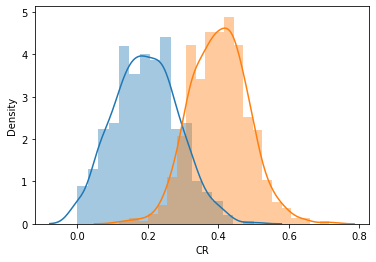

In [43]:
sns.distplot(first_group_CR.CR)
sns.distplot(second_group_CR.CR)

In [44]:
# Since the distributions are normal and we have 2 independent groups of observations, we apply the t-test
ss.ttest_ind(first_group_CR.CR, second_group_CR.CR)

Ttest_indResult(statistic=-38.234590527591905, pvalue=1.0344736796458603e-197)

The p-value is less than 0.05, so we conclude that the averages in the two groups are significantly different

In [45]:
second_group_CR.CR.mean() / first_group_CR.CR.mean()

2.0783902623290196

#### We conclude that the averages are significantly different and the new algorithm has significantly increased the average user activity (by 2 times).

### The two positive answers to the questions we posed at the beginning of our analysis allow us to conclude that in our sample the new questionnaire selection system proved successful and can be considered for implementation.